# Tune-up Template 

## 0. Chip Layout, Wiring, and Fabrication 

### 0.1 Chip layout

Put your chip layout here

### 0.2 Wiring

Describe your wiring here

### 0.3 Fabrication Parameters

You might know something about your qubits from fabrication, you can put those here before you start:

|                  | QB1               | QB2          | QB3               | QB4               | QB5          | QB6               |
|------------------|-------------------|--------------|-------------------|-------------------|--------------|-------------------|
| Upper Sweet Spot |  |  |  |  |  |  |
| Lower Sweet Spot |  |  |  |  |  |  |
| Resonator        | 7.0G              | 7.2G         | 7.4G              | 7.1G              | 7.3G         | 7.5G              |

## 1. Imports


# Tune-up Template 

## 0. Chip Layout, Wiring, and Fabrication 

### 0.1 Chip layout

Put your chip layout here

### 0.2 Wiring

Describe your wiring here

### 0.3 Fabrication Parameters

You might know something about your qubits from fabrication, you can put those here before you start:

|                  | QB1               | QB2          | QB3               | QB4               | QB5          | QB6               |
|------------------|-------------------|--------------|-------------------|-------------------|--------------|-------------------|
| Upper Sweet Spot |  |  |  |  |  |  |
| Lower Sweet Spot |  |  |  |  |  |  |
| Resonator        | 7.0G              | 7.2G         | 7.4G              | 7.1G              | 7.3G         | 7.5G              |

## 1. Imports


In [1]:
# convenience Import for all LabOne Q Functionality
from laboneq.simple import *

# plotting and fitting functionality
from laboneq.contrib.example_helpers.data_analysis.data_analysis import (
    func_invLorentz,
    func_osc,
    fit_Spec,
    fit_Rabi,
    func_decayOsc,
    fit_Ramsey,
)
from laboneq.contrib.example_helpers.plotting.plot_helpers import (
    plot_simulation,
    plot_results,
)

# descriptor imports
from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor

# for saving results and pulse sheets
from pathlib import Path
import datetime
import time
import scipy
import json
import yaml
from ruamel.yaml import YAML

import matplotlib.pyplot as plt
import numpy as np

from helpers.tuneup_helper import (
    flatten,
    rotate_to_real_axis,
    calc_readout_weight,
    evaluate_rabi,
    evaluate_ramsey,
    evaluate_T1,
    analyze_ACStark,
    analyze_qspec,
    create_x180,
    create_x180_ef,
    create_x90,
    create_x90_ef,
    update_qubit_parameters_and_calibration,
    load_qubit_parameters,
    create_transmon,
    save_results,
    plot_with_trace_rabi,
)

from helpers.experiment_library import (
    resonator_spectroscopy_parallel_CW_full_range,
    resonator_spectroscopy_single,
    readout_pulse,
    integration_kernel,
    pulsed_resonator_spectroscopy_single,
    qubit_spectroscopy_parallel,
    qubit_spectroscopy_single,
    res_spectroscopy_pulsed_amp_sweep,
    amplitude_rabi_parallel,
    amplitude_rabi_single,
    ramsey_parallel,
    t1_parallel,
    ecr_amplitude_sweep,
    create_freq_sweep,
    qubit_drive_pulse,
    create_amp_sweep,
    readout_gauss_square_pulse,
    qubit_gaussian_pulse,
)

import logging

from helpers.experiment_library import qubit_spectroscopy_single

## 2. Set-up


### Emulation Mode


In [2]:
emulate = False

### Database Set-up


In [3]:
# set up connection to database
demo_setup_db = DataStore("laboneq_data/setup_database.db")

demo_results_db = DataStore("laboneq_data/results_database.db")

# # check if data is already stored in database
# for key in demo_setup_db.keys():
#     print(key)

### Device Set-up


In [4]:
from textwrap import dedent

descriptor = dedent(
    """\
instruments:
  SHFQC:
    - address: dev12250
      uid: device_shfqc
connections:

  device_shfqc:
    - iq_signal: q0/measure_line
      ports: QACHANNELS/0/OUTPUT
    - acquire_signal: q0/acquire_line
      ports: QACHANNELS/0/INPUT
      
    - iq_signal: q0/drive_line
      ports: SGCHANNELS/3/OUTPUT
"""
)
demo_setup = DeviceSetup.from_descriptor(
    descriptor, server_host="localhost", server_port=8004, setup_name="MySetup"
)

### Apply Calibration from File


In [5]:
qubit_parameters = load_qubit_parameters()

qubit_parameters["local_oscillators"]["readout_lo"]["value"] = 7.0e9

transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)
print(demo_setup.get_calibration())

Calibration(
│   calibration_items={
│   │   '/logical_signal_groups/q0/drive_line': SignalCalibration(
│   │   │   oscillator=Oscillator(
│   │   │   │   uid='q0_drive_ge_osc',
│   │   │   │   frequency=748916569.4626274,
│   │   │   │   modulation_type=ModulationType.HARDWARE,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_drive_local_osc',
│   │   │   │   frequency=5000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=None,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-25,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/logical_signal_groups/q0/measure_line': SignalCalibration(
│   │   │   oscillator=Oscillator(
│   │   │   │   uid='q0_measure_osc',
│   │   │   │   frequency=260000000.0,
│   │   │   │   modulation_type=ModulationType.SOFTWARE,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=None,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-25,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/logical_signal_groups/q0/acquire_line': SignalCalibration(
│   │   │   oscillator=Oscillator(
│   │   │   │   uid='q0_acquire_osc',
│   │   │   │   frequency=260000000.0,
│   │   │   │   modulation_type=ModulationType.SOFTWARE,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=2.4e-07,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-5,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/physical_channel_groups/device_shfqc/qachannels_0_output': SignalCalibration(
│   │   │   oscillator=None,
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=None,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-25,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/physical_channel_groups/device_shfqc/qachannels_0_input': SignalCalibration(
│   │   │   oscillator=None,
│   │   │   local_oscillator=Oscillator(
│   │   │   │   uid='q0_readout_local_osc',
│   │   │   │   frequency=7000000000.0,
│   │   │   │   modulation_type=ModulationType.AUTO,
│   │   │   │   carrier_type=CarrierType.RF
│   │   │   ),
│   │   │   mixer_calibration=None,
│   │   │   precompensation=None,
│   │   │   port_delay=2.4e-07,
│   │   │   port_mode=None,
│   │   │   delay_signal=None,
│   │   │   voltage_offset=None,
│   │   │   range=-5,
│   │   │   threshold=None,
│   │   │   amplitude=None,
│   │   │   amplifier_pump=None
│   │   ),
│   │   '/physical_channel_groups/device_shfqc/sgchannels_3_output': SignalCalibra

### Create and Connect to a QCCS Session 

Establishes the connection to the instruments and readies them for experiments


In [6]:
# create and connect to a session
session = Session(device_setup=demo_setup)
session.connect(do_emulation=emulate, reset_devices=True)

2023.09.21 06:52:52.263 laboneq.controller.laboneq_logging INFO   Logging initialized from [Default inline config in laboneq.controller.laboneq_logging] logdir is c:\Users\ZI_at_PSI\code\Tune_up_scripts\laboneq_output\log
2023.09.21 06:52:52.264 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.21 06:52:52.265 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.21 06:52:52.310 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.21 06:52:53.715 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.21 06:52:53.849 laboneq.controller.devices.device_collection INFO   The device setup is configured


## CW Spectroscopy


In [10]:
cw_spectroscopy_exp = resonator_spectroscopy_parallel_CW_full_range(
    transmon_list,
    create_freq_sweep("outer", 6e9, 8e9, 3),
    create_freq_sweep("inner", -500e6, 500e6, 1001),
)

compiled_cw_spectroscopy_exp = session.compile(cw_spectroscopy_exp)
cw_spectroscopy_results = session.run(compiled_cw_spectroscopy_exp)

2023.09.20 21:37:00.631 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.20 21:37:00.741 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.20 21:37:00.956 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 25
2023.09.20 21:37:00.956 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 0
2023.09.20 21:37:00.957 laboneq.compiler.workflow.compiler INFO   Finished LabOne Q Compiler run.
2023.09.20 21:37:01.510 laboneq.controller.controller  INFO   Starting near-time execution...
2023.09.20 21:37:01.832 laboneq.controller.controller  INFO   Estimated RT execution time: 10.01 s.
2023.09.20 21:37:12.264 laboneq.controller.controller  INFO   Estimated RT execution time: 10.01 s.
2023.09.20 21:37:22.697 laboneq.controller.controller  INFO   Estimated RT execution time: 10.01 s.
2023.09.20 21:37:32.912 laboneq.controller.controller  INFO   Finished near-time execution.


Text(0.5, 1.0, 'CW resonator spectroscopy, large range')

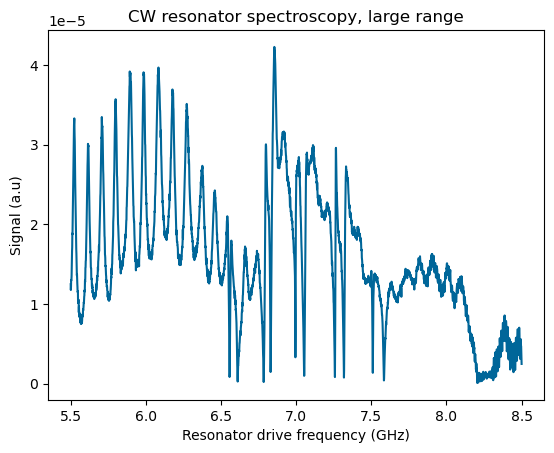

In [13]:
# access and plot results of one 8GHz sweep
full_data = abs(cw_spectroscopy_results.get_data("resonator_spectroscopy_q0"))

outer = cw_spectroscopy_results.get_axis("resonator_spectroscopy_q0")[0]
inner = cw_spectroscopy_results.get_axis("resonator_spectroscopy_q0")[1]
full_sweep = np.array(flatten([out + inner for out in outer]))

plt.plot(full_sweep/1e9, np.array(flatten([data for data in full_data])))
plt.xlabel("Resonator drive frequency (GHz)")
plt.ylabel("Signal (a.u)")
plt.title("CW resonator spectroscopy, large range")

In [14]:
save_results(demo_results_db, cw_spectroscopy_results, "cw_spec_results", "full_sweep")

# Baseband sweep CW spectroscopy

In [7]:
single_cw = resonator_spectroscopy_single(
    transmon_list[0],
    create_freq_sweep(f"{transmon_list[0].uid}_sweep", 230e6, 270e6, 100),
    measure_range=-25,
    acquire_range=-5,
)
session.connect(do_emulation=emulate, reset_devices=True)
compiled_single_cw_spect_exp = session.compile(single_cw)
cw_spectroscopy_results = session.run(compiled_single_cw_spect_exp)
#plot_results(cw_spectroscopy_results)

2023.09.21 06:52:57.598 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.21 06:52:57.599 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.21 06:52:57.606 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.21 06:52:58.977 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.21 06:52:59.124 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.21 06:52:59.362 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.21 06:52:59.374 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.21 06:52:59.391 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 25
2023.09.21 06:52:59.391 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 0
2023.09.21 06:52:59.392 laboneq.compiler.workflow.co

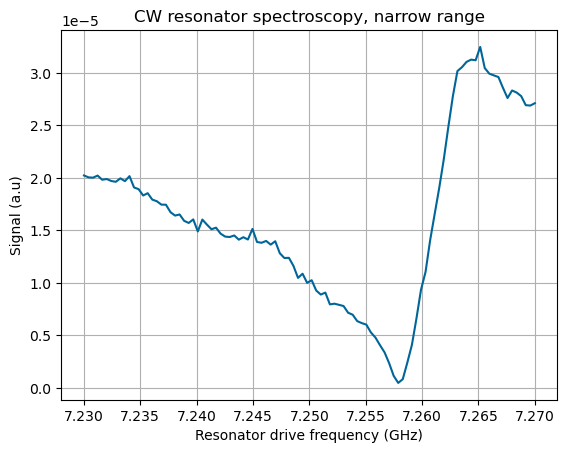

In [8]:
lo_frequency = cw_spectroscopy_results.experiment.signals["measure_q0"].calibration.local_oscillator.frequency

full_data = abs(cw_spectroscopy_results.get_data("resonator_spectroscopy_q0"))
full_sweep = cw_spectroscopy_results.get_axis("resonator_spectroscopy_q0")[0] + lo_frequency

plt.plot(full_sweep/1e9, full_data)
plt.xlabel("Resonator drive frequency (GHz)")
plt.ylabel("Signal (a.u)")
plt.title("CW resonator spectroscopy, narrow range")
plt.grid()

In [17]:
#analyze_qspec(res=cw_spectroscopy_results, handle="resonator_spectroscopy_q0")

In [9]:
first_readout_res = lo_frequency + 0.26e9
print(first_readout_res)

7260000000.0


In [10]:
qubit_parameters["qubits"]["q0"]["readout_resonator_frequency"][
    "value"
] = first_readout_res

transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

# Spectroscopy vs Power - "Punchout" NOT TESTED


In [13]:
if False:
    freq_upper = (
        transmon_list[0].parameters.readout_resonator_frequency
        - transmon_list[0].parameters.readout_lo_frequency
        + 50e6
    )
    freq_lower = (
        transmon_list[0].parameters.readout_resonator_frequency
        - transmon_list[0].parameters.readout_lo_frequency
        - 50e6
    )

    amp_sweep = SweepParameter(
        uid="amp_sweep2",
        values=np.logspace(start=np.log10(0.001), stop=np.log10(1), num=21),
    )

    punchout = res_spectroscopy_pulsed_amp_sweep(
        qubit=transmon_list[0],
        integration_kernel=integration_kernel,
        readout_pulse=readout_gauss_square_pulse,
        frequency_sweep=create_freq_sweep(
            f"{transmon_list[0].uid}_sweep", freq_lower, freq_upper, 1001
        ),
        amplitude_sweep=amp_sweep,
        num_averages=2**10,
        measure_range=-25,
        acquire_range=-5,
    )

    comp_punchout = session.compile(punchout)
    punchout_result = session.run(comp_punchout)

    plot_results(punchout_result)

In [14]:
if False:
    save_results(
        demo_results_db,
        punchout_result,
        "punchout",
        "neg_25_meas_neg_5_acq_range",
    )

In [15]:
if False:
    qubit_parameters["multiplex_readout"]["readout_amplitude"]["value"] = 0.55

    transmon_list = update_qubit_parameters_and_calibration(
        qubit_parameters, demo_setup, demo_setup_db
    )

## Continue with your tune-up experiments:

* Qubit Spec
* Rabi
* Ramsey
* T1
* Hahn Echo

What's after that? There are many ways to go once you have done the basics:

* Drag pulse tune-up
* Single shot readout
* Active reset
* f-level tune-up
* Two qubit gates
* Tomography
* RB

# Qubit Spectroscopy

In [11]:
def gen_const_pulse(qubit, length=5e-5,amplitude=1.0):
    return pulse_library.const(uid=f"{qubit}",length=length,amplitude=amplitude, can_compress=True)

In [12]:
qubit_parameters["qubits"]["q0"]["drive_range_ge"]["value"]=-25
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

In [13]:

qubit_spec_exp = qubit_spectroscopy_single(
    qubit = transmon_list[0],
    integration_kernel=integration_kernel,
    readout_pulse=readout_pulse,
    qubit_spectroscopy_pulse=gen_const_pulse,
    qspec_range=6e6,
    qspec_num=251,
    num_averages=2**9,
)


In [14]:
session.connect(do_emulation=emulate,reset_devices=True)
qspec_res=session.run(qubit_spec_exp)
#plot_results(qspec_res)

2023.09.21 06:53:19.997 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.21 06:53:19.998 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.21 06:53:20.006 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.21 06:53:21.378 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.21 06:53:21.527 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.21 06:53:21.775 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.21 06:53:21.804 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.21 06:53:22.462 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 37
2023.09.21 06:53:22.463 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 8064
2023.09.21 06:53:22.463 laboneq.compiler.workflow

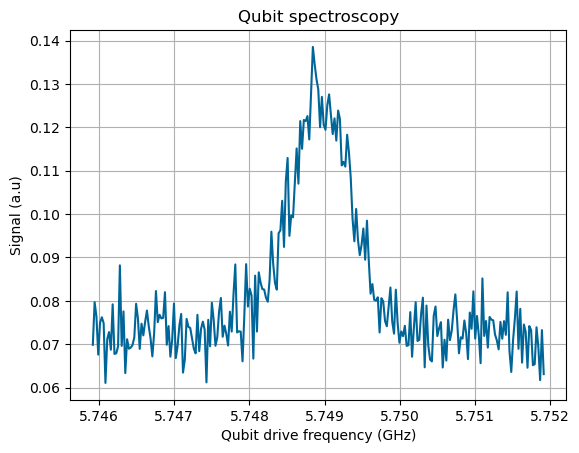

In [15]:
lo_frequency = qubit_parameters["qubits"]["q0"]["drive_lo_frequency"]["value"]

full_data = abs(qspec_res.get_data("q0_spectroscopy"))
full_sweep = qspec_res.get_axis("q0_spectroscopy")[0] + lo_frequency

plt.plot(full_sweep/1e9, full_data)
plt.xlabel("Qubit drive frequency (GHz)")
plt.ylabel("Signal (a.u)")
plt.title("Qubit spectroscopy")
plt.grid()

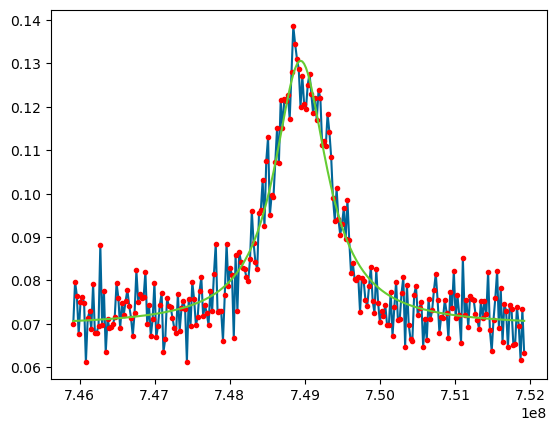

748942572.79524


In [16]:
qubit_resonance=analyze_qspec(qspec_res,"q0_spectroscopy",f0=7.49e8,a=0.03,gamma=1E6, flip=False)
print(qubit_resonance)

### Update qubit resonance

In [17]:
qubit_parameters["qubits"]["q0"]["resonance_frequency_ge"][
    "value"
] =  qubit_parameters["qubits"]["q0"]["drive_lo_frequency"][
    "value"
] + qubit_resonance
print(qubit_parameters["qubits"]["q0"]["resonance_frequency_ge"]["value"])
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

5748942572.79524


# Amplitude Rabi

In [18]:
qubit_parameters["qubits"]["q0"]["drive_range_ge"]["value"]=10
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

In [19]:
def amplitude_rabi_single(
    qubit,
    drive_pulse,
    integration_kernel,
    readout_pulse,
    amplitude_sweep,
    num_averages=2**10,
    cal_trace=False,
    pi_amplitude=0.5,
):
    exp_rabi = Experiment(
        uid="Qubit Spectroscopy",
        signals=flatten(
            [
                [
                    ExperimentSignal(
                        f"drive_{qubit.uid}", map_to=qubit.signals["drive"]
                    ),
                    ExperimentSignal(
                        f"measure_{qubit.uid}", map_to=qubit.signals["measure"]
                    ),
                    ExperimentSignal(
                        f"acquire_{qubit.uid}", map_to=qubit.signals["acquire"]
                    ),
                ]
            ]
        ),
    )

    ## define Rabi experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_rabi.acquire_loop_rt(
        uid="rabi_shots",
        count=num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        # inner loop - real time sweep of Rabi amplitudes
        with exp_rabi.sweep(uid="rabi_sweep", parameter=amplitude_sweep):
                # qubit drive
                with exp_rabi.section(
                    uid=f"{qubit.uid}_excitation", alignment=SectionAlignment.RIGHT
                ):
                    exp_rabi.play(
                        signal=f"drive_{qubit.uid}",
                        pulse=drive_pulse(qubit, amplitude=1),
                        amplitude=amplitude_sweep,
                    )
                # measurement
                with exp_rabi.section(
                    uid=f"readout_{qubit.uid}", play_after=f"{qubit.uid}_excitation"
                ):
                    exp_rabi.measure(
                        measure_signal=f"measure_{qubit.uid}",
                        measure_pulse=readout_pulse(qubit),
                        handle=f"{qubit.uid}_rabi",
                        acquire_signal=f"acquire_{qubit.uid}",
                        integration_kernel=integration_kernel(qubit),
                        reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                    )
        if cal_trace:
            with exp_rabi.section(uid="cal_trace_gnd_meas"):
                exp_rabi.measure(
                    measure_signal=f"measure_{qubit.uid}",
                    measure_pulse=readout_pulse(qubit),
                    handle=f"{qubit.uid}_rabi_cal_trace",
                    acquire_signal=f"acquire_{qubit.uid}",
                    integration_kernel=integration_kernel(qubit),
                    reset_delay=1e-6, # qubit.parameters.user_defined["reset_delay_length"],
                )
            with exp_rabi.section(uid="cal_trace_exc", play_after="cal_trace_gnd_meas"):
                exp_rabi.play(
                    signal=f"drive_{qubit.uid}",
                    pulse=drive_pulse(qubit, amplitude = 1),
                    amplitude = pi_amplitude,
                )
                
            with exp_rabi.section(uid="cal_trace_exc_meas", play_after="cal_trace_exc"):
                exp_rabi.measure(
                    measure_signal=f"measure_{qubit.uid}",
                    measure_pulse=readout_pulse(qubit),
                    handle=f"{qubit.uid}_rabi_cal_trace",
                    acquire_signal=f"acquire_{qubit.uid}",
                    integration_kernel=integration_kernel(qubit),
                    reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                )
            

    return exp_rabi

In [20]:
amplitude_sweep=LinearSweepParameter(uid="amplitude_sweep", start=0.0, stop=0.9, count=51)


amp_rabi = amplitude_rabi_single(
    qubit=transmon_list[0],
    drive_pulse=qubit_drive_pulse,
    integration_kernel=integration_kernel,
    readout_pulse=readout_pulse,
    amplitude_sweep=amplitude_sweep,
    num_averages=2**10,
    pi_amplitude=transmon_list[0].parameters.user_defined["amplitude_pi"],
    cal_trace=True,
)

compiled_rabi = session.compile(amp_rabi)
session.connect(do_emulation=emulate, reset_devices=True)
rabi_res = session.run(compiled_rabi)


2023.09.21 06:54:06.978 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.21 06:54:06.985 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.21 06:54:07.019 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 188
2023.09.21 06:54:07.020 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 8832
2023.09.21 06:54:07.021 laboneq.compiler.workflow.compiler INFO   Finished LabOne Q Compiler run.
2023.09.21 06:54:07.023 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.21 06:54:07.023 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.21 06:54:07.030 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.21 06:54:08.366 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.21 06:54:08.512 laboneq.controller.devices.device

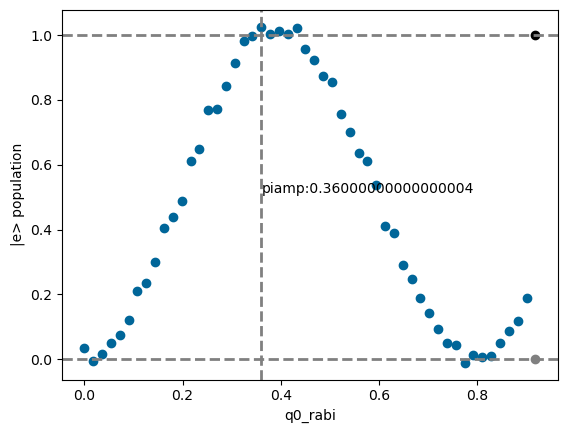

In [21]:
plot_with_trace_rabi(rabi_res)

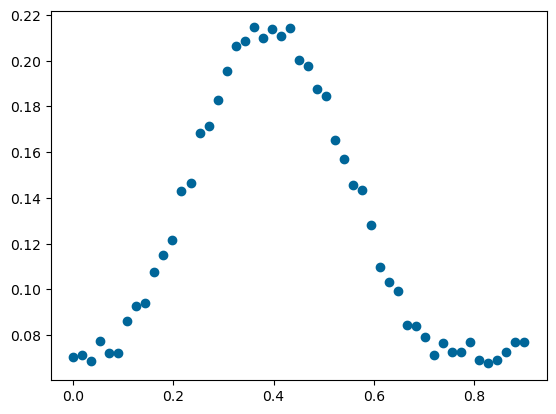

[0.12558761459402049, 1.5707963267948966, 0.07349974443750674, 0.468]
[0.13564969 1.65991502 0.07323992 0.3848072 ]
Pi amp: 0.3957187500000001, pi/2 amp: 0.20334688110351568


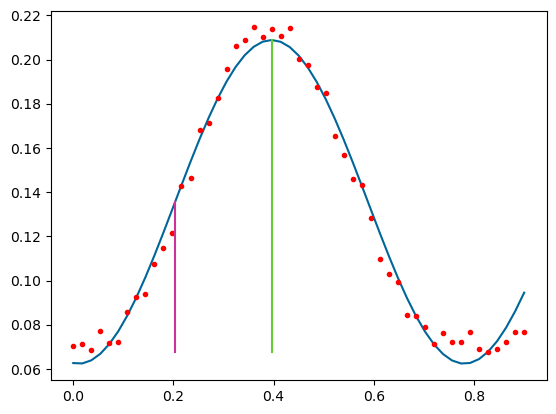

In [22]:
[pi_amp, pi2_amp] = evaluate_rabi(rabi_res, "q0_rabi")

In [23]:
qubit_parameters["qubits"]["q0"]["amplitude_pi"][
    "value"
] = float(pi_amp)
qubit_parameters["qubits"]["q0"]["amplitude_pi2"][
    "value"
] = float(pi2_amp)


transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

## T1 measurement

In [24]:
delay_sweep=LinearSweepParameter(uid="delay_sweep", start=1e-10, stop=100e-6, count=51)

t1_meas = t1_parallel(
    qubits=[transmon_list[0]],
    drive_pulse=qubit_drive_pulse,
    integration_kernel=integration_kernel,
    readout_pulse=readout_pulse,
    delay_sweep=delay_sweep,
    num_averages=2**10,
)

compiled_t1 = session.compile(t1_meas)
session.connect(do_emulation=emulate, reset_devices=True)
t1_res = session.run(compiled_t1)

2023.09.21 06:54:31.613 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.21 06:54:31.625 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.21 06:54:31.664 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 313
2023.09.21 06:54:31.665 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 8416
2023.09.21 06:54:31.665 laboneq.compiler.workflow.compiler INFO   Finished LabOne Q Compiler run.
2023.09.21 06:54:31.666 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.21 06:54:31.667 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.21 06:54:31.671 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.21 06:54:33.108 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.21 06:54:33.254 laboneq.controller.devices.device

T1 found to be 11.877 us.


1.1876530658494819e-05

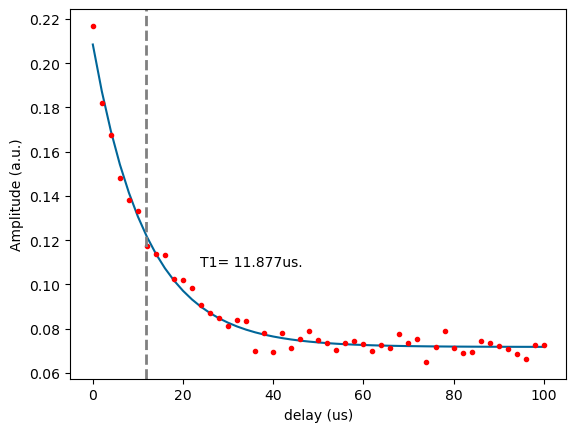

In [25]:
evaluate_T1(t1_res, "q0_t1")

## Ramsey

In [26]:
def ramsey_parallel(
    qubits,
    drive_pulse: callable,
    integration_kernel: callable,
    readout_pulse: callable,
    delay_sweep,
    num_averages=2**10,
    detuning = 0,
    cal_trace=False,
):
    exp_ramsey = Experiment(
        uid="Ramsey Exp",
        signals=flatten(
            [
                [
                    ExperimentSignal(
                        f"drive_{qubit.uid}", map_to=qubit.signals["drive"]
                    ),
                    ExperimentSignal(
                        f"measure_{qubit.uid}", map_to=qubit.signals["measure"]
                    ),
                    ExperimentSignal(
                        f"acquire_{qubit.uid}", map_to=qubit.signals["acquire"]
                    ),
                ]
                for qubit in qubits
            ]
        ),
    )


    

 #   readout_weight = readout_pulse
    freq = qubits[0].parameters.resonance_frequency_ge + detuning - qubits[0].parameters.drive_lo_frequency
  #  else:
   #     freq = detuning
         
    
    calibration = Calibration()   
    calibration["drive_q0"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq,
            modulation_type=ModulationType.HARDWARE
        )
    )

    exp_ramsey.set_calibration(calibration)

    ## define Ramsey experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_ramsey.acquire_loop_rt(
        uid="ramsey_shots",
        count=num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        repetition_mode=RepetitionMode.AUTO,
    ):
        # inner loop - real time sweep of Ramsey time delays
        with exp_ramsey.sweep(
            uid="ramsey_sweep", parameter=delay_sweep, alignment=SectionAlignment.RIGHT
        ):
            for qubit in qubits:
                # play qubit excitation pulse - pulse amplitude is swept
                ramsey_pulse = drive_pulse(qubit)
                with exp_ramsey.section(
                    uid=f"{qubit.uid}_excitation", alignment=SectionAlignment.RIGHT
                ):
                    exp_ramsey.play(signal=f"drive_{qubit.uid}", pulse=ramsey_pulse)
                    exp_ramsey.delay(signal=f"drive_{qubit.uid}", time=delay_sweep)
                    exp_ramsey.play(signal=f"drive_{qubit.uid}", pulse=ramsey_pulse)
                # readout pulse and data acquisition
                # measurement
                with exp_ramsey.section(
                    uid=f"readout_{qubit.uid}", play_after=f"{qubit.uid}_excitation"
                ):
                    exp_ramsey.measure(
                        measure_signal=f"measure_{qubit.uid}",
                        measure_pulse=readout_pulse(qubit),
                        handle=f"{qubit.uid}_ramsey",
                        acquire_signal=f"acquire_{qubit.uid}",
                        integration_kernel=integration_kernel(qubit),
                        reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                    )
                    
                
                if cal_trace:
                    with exp_ramsey.section(uid="cal_trace_gnd"):
                        exp_ramsey.measure(
                            measure_signal=f"measure_{qubit.uid}",
                            measure_pulse=readout_pulse(qubit),
                            handle=f"{qubit.uid}_ramsey_cal_trace",
                            acquire_signal=f"acquire_{qubit.uid}",
                            integration_kernel=integration_kernel(qubit),
                            reset_delay=1e-6 # qubit.parameters.user_defined["reset_delay_length"],
                        )
                    with exp_ramsey.section(uid="cal_trace_exc"):
                        exp_ramsey.play(
                            signal=f"drive_{qubit.uid}",
                            pulse=drive_pulse(qubit),
                            amplitude=qubits[0].parameters.user_defined['amplitude_pi'],
                        )
                        
                        exp_ramsey.measure(
                            measure_signal=f"measure_{qubit.uid}",
                            measure_pulse=readout_pulse(qubit),
                            handle=f"{qubit.uid}_ramsey_cal_trace",
                            acquire_signal=f"acquire_{qubit.uid}",
                            integration_kernel=integration_kernel(qubit),
                            reset_delay=qubit.parameters.user_defined["reset_delay_length"],
                        )

    return exp_ramsey

In [27]:
qubit_parameters["qubits"]["q0"]["reset_delay_length"]["value"] = 100e-6
transmon_list = update_qubit_parameters_and_calibration(
    qubit_parameters, demo_setup, demo_setup_db
)

In [28]:
def qubit_gaussian_halfpi_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_pulse_drive_{qubit.uid}",
        length=qubit.parameters.user_defined["pulse_length"],
        amplitude = qubit.parameters.user_defined["amplitude_pi2"],
    )

### Set detuning freq

In [29]:
detuning_freq = .3e6

In [30]:
delay_sweep = LinearSweepParameter(uid="delay_sweep", start=0, stop=40e-6, count=151)
ramsey_exp = ramsey_parallel(transmon_list, qubit_gaussian_halfpi_pulse, integration_kernel, readout_pulse, delay_sweep, num_averages=2**10, detuning=detuning_freq, cal_trace=False)
session.connect(reset_devices=True)
compiled_exp = session.compile(ramsey_exp)
res_ramsey=session.run(compiled_exp)
#show_pulse_sheet(ramsey_exp.uid,compiled_exp)

2023.09.21 06:54:53.133 laboneq.controller.controller  INFO   VERSION: laboneq 2.13.0
2023.09.21 06:54:53.134 laboneq.controller.devices.device_collection INFO   Connecting to data server at localhost:8004
2023.09.21 06:54:53.140 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
2023.09.21 06:54:54.545 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.09.21 06:54:54.688 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.09.21 06:54:54.916 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.09.21 06:54:54.936 laboneq.compiler.scheduler.scheduler INFO   Schedule completed
2023.09.21 06:54:55.027 laboneq.compiler.workflow.compiler INFO   Total seqC lines generated: 934
2023.09.21 06:54:55.027 laboneq.compiler.workflow.compiler INFO   Total sample points generated: 10496
2023.09.21 06:54:55.028 laboneq.compiler.workfl

[0.13773719344784255, 1.5707963267948966, 0.06449654543634914, 1.0133333333333333e-05, 1e-05]
Detuned by 0.2929555173263837 MHz; T2 found to be 11.646107855446397 us.


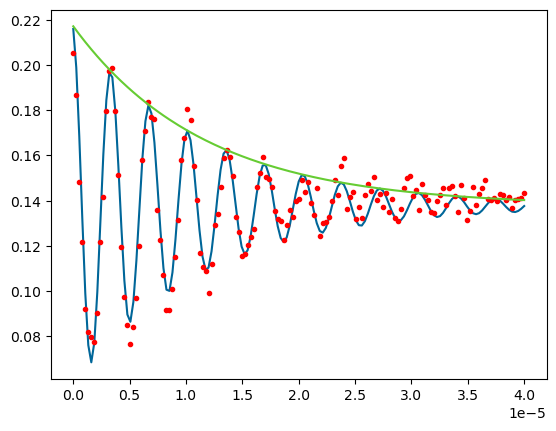

In [31]:
[t2, detuning_freq_measured] = evaluate_ramsey(res_ramsey, 'q0_ramsey')